In [1]:

# Access modules in the py folder
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# Get needed libraries
from FRVRS import (fu, nu, np, osp, DataFrame, Series, concat, notnull, re, display, read_excel, walk, isna)
import os
import pandas as pd


# Exploratory Analysis of Open World ITM Data

In [4]:

if nu.pickle_exists('ow_participants_df'): participants_df = nu.load_object('ow_participants_df')
else:
    
    # load data frames
    data_frames_dict = nu.load_data_frames(
        metrics_evaluation_open_world_csv_stats_df='', metrics_evaluation_open_world_json_stats_df='',
        metrics_evaluation_open_world_scene_stats_df=''
    )
    logs_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df']
    json_stats_df = data_frames_dict['metrics_evaluation_open_world_json_stats_df']
    scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df']
    
    participants_df = DataFrame([])
    for participant_id in range(2_024_201, 2_024_223+1):
        ldf = logs_df[logs_df.participant_id == participant_id]
        fsdf = json_stats_df[json_stats_df.participant_id == participant_id]
        ssdf = scene_stats_df[scene_stats_df.participant_id == participant_id]
        on_columns = sorted(set(ldf.columns).intersection(set(fsdf.columns)))
        participant_elevens_df = ldf.merge(fsdf, on=on_columns)
        on_columns = sorted(set(participant_elevens_df.columns).intersection(set(ssdf.columns)))
        participant_elevens_df = participant_elevens_df.merge(ssdf, on=on_columns)
        if participant_elevens_df.shape[0]: participants_df = concat([participants_df, participant_elevens_df], axis='index')
    nu.store_objects(ow_participants_df=participants_df)
    nu.save_data_frames(ow_participants_df=participants_df)

In [4]:

# Remove the Unity suffix from all patient_id columns
# The one without "Root" is the ID that CACI sets for it. Unity
# then takes the ID and adds "Root" to the end when it
# creates the hierarchy, so there's less room for human
# error. They're going to match perfectly.
for cn in fu.patient_id_columns_list + ['patient_id']:
    if cn in csv_stats_df.columns:
        mask_series = ~csv_stats_df[cn].isnull()
        csv_stats_df.loc[mask_series, cn] = csv_stats_df[mask_series][cn].map(lambda x: str(x).replace(' Root', ''))

In [21]:

# Patients in our simulations are always given their same SORT designation
from IPython.display import HTML

mask_series = ~participants_df.patient_sort.isnull() & participants_df.patient_id.isin(
    fu.desert_patients_list + fu.jungle_patients_list + fu.submarine_patients_list + fu.urban_patients_list
)
columns_list = ['patient_id', 'patient_sort']

# Tabulate how many wavers, how many still, etc.
# HTML(participants_df[mask_series][columns_list].drop_duplicates().sort_values(columns_list).reset_index(drop=True).to_html())
tuples_list = []
for index, value in participants_df[mask_series][columns_list].drop_duplicates().sort_values(
    columns_list
).patient_sort.value_counts().iteritems():
    tuples_list.append(f'{value} patients have a {index} designation')
print(nu.conjunctify_nouns(tuples_list))

10 patients have a waver designation, 6 patients have a still designation, and 1 patients have a walker designation


In [6]:

# The following data points were analyzed for each participant for each scene
if nu.pickle_exists('ow_participant_scenes_df'): participant_scenes_df = nu.load_object('ow_participant_scenes_df')
else:
    rows_list = []
    for (participant_id, encounter_layout, session_uuid, scene_id), scene_df in participants_df.groupby(
        ['participant_id', 'encounter_layout', 'session_uuid', 'scene_id']
    ):
        row_dict = {
            'participant_id': participant_id, 'encounter_layout': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id
        }
        
        # Total number of actions: Overall number of actions taken by the participant
        mask_series = scene_df.action_type.isin(fu.action_types_list)
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]
        
        # Count of assessment actions: Number of actions related to patient evaluation
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # Count of treatment actions: Number of actions related to patient treatment
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # Count of tags applied: Number of tag application events (e.g., yellow, green)
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
        
        # Treat expectant patient (yes/no): Binary variable indicating taking time to treat patients expected to die anyway
        row_dict['is_treating_expectants'] = fu.get_is_treating_expectants(scene_df)
        
        # Triage efficiency: Number of swaps it takes to get the sequence (in which patients were interacted with) to the ideal
        actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df)
        unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
        swaps_to_perfect_order_count = nu.count_swaps_to_perfect_order(
            [unsort_dict[i] for i in ideal_sequence], [unsort_dict[a] for a in actual_sequence]
        )
        row_dict['swaps_to_perfect_order_count'] = swaps_to_perfect_order_count
        
        # Time to hemorrhage control: Time taken to control bleeding for an entire simulated scene
        scene_start = fu.get_scene_start(scene_df)
        row_dict['scene_start'] = scene_start
        controlled_time = fu.get_time_to_last_hemorrhage_controlled(scene_df)
        row_dict['time_to_hemorrhage_control'] = controlled_time
    
        rows_list.append(row_dict)
    
    participant_scenes_df = DataFrame(rows_list)
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)


## Study Summary Statistics Columns

Can you please give this some more thought on this and revise? What type of stats would make sense for continuous variables? What about grouping variables? etc?

Maybe I am not understanding these variables, but do mean and std_dev make sense to report here? They are just counts in the experiments, and levels, right?

In [24]:

# By analyzing the visualizations and exploring additional DVs, we can identify metrics with high variability across
# environments, fidelities, and performers
summary_statistics_columns = [
    'total_assessment_count', 'total_tag_application_count', 'total_treatment_count', 'mean_first_patient_interaction', 'total_action_count',
    'max_time_to_hemorrhage_control', 'triage_time', 'time_to_last_hemorrhage_controlled', 'total_patient_engagement_count',
    'time_to_hemorrhage_control_per_patient', 'mean_percentage_tag_correct', 'mean_last_patient_interaction', 'MedExp', 'AD_KDMA_Sim',
    'ST_ConfFC_Omni_Text',
    'ST_ConfFC_Text', 'AD_ConfFC_Text', 'AD_Del_Text', 'AD_ConfFC_Omni_Text', 'Trust', 'ST_KDMA_Sim', 'ST_AttribGrp_Text', 'AD_KDMA_Text',
    'ST_Del_Text',
    'AD_AttribGrp_Sim', 'AD_AttribGrp_Text', 'PropTrust', 'ST_AttribGrp_Sim', 'YrsMilExp', 'AD_Del_Omni_Text', 'MilitaryExp', 'Delegation',
    'ST_KDMA_Text',
    'MedRole', 'ST_Del_Omni_Text'
]
for df in [participants_df, participant_scenes_df]:
    columns_list = list(set(summary_statistics_columns).intersection(set(df.columns)))
    if columns_list: display(df[columns_list].var().sort_values())

ST_Del_Omni_Text                          0.000000e+00
ST_KDMA_Sim                               1.811487e-03
ST_Del_Text                               4.252695e-03
ST_KDMA_Text                              8.161331e-03
AD_KDMA_Text                              1.023561e-02
AD_KDMA_Sim                               1.343596e-02
Delegation                                1.802180e-02
AD_Del_Omni_Text                          4.794146e-02
AD_Del_Text                               7.009521e-02
Trust                                     1.276341e-01
MilitaryExp                               1.645939e-01
AD_AttribGrp_Sim                          2.310271e-01
PropTrust                                 2.398591e-01
ST_AttribGrp_Sim                          2.454508e-01
ST_AttribGrp_Text                         2.478955e-01
AD_AttribGrp_Text                         2.480925e-01
ST_ConfFC_Text                            2.908187e-01
AD_ConfFC_Text                            3.911147e-01
ST_ConfFC_

In [51]:

        # print(unique_count, cn, sep='\t')
display(nuniques_dict.get(2, []))

['ST_AttribGrp_Sim', 'AD_AttribGrp_Text', 'AD_AttribGrp_Sim', 'MilitaryExp', 'ST_AttribGrp_Text', 'ST_Del_Text', 'AD_Del_Omni_Text']

In [54]:

print('\nnuniques_df = DataFrame([')
for row_dict in nuniques_df.to_dict('records'):
    print(f'    {row_dict}')
print('])')


nuniques_df = DataFrame([
    {'column_name': 'ST_AttribGrp_Sim', 'column_value': 1.0, 'value_count': 11}
    {'column_name': 'ST_AttribGrp_Sim', 'column_value': 0.0, 'value_count': 11}
    {'column_name': 'AD_AttribGrp_Text', 'column_value': 0.0, 'value_count': 12}
    {'column_name': 'AD_AttribGrp_Text', 'column_value': 1.0, 'value_count': 10}
    {'column_name': 'AD_AttribGrp_Sim', 'column_value': 0.0, 'value_count': 14}
    {'column_name': 'AD_AttribGrp_Sim', 'column_value': 1.0, 'value_count': 8}
    {'column_name': 'MilitaryExp', 'column_value': 0.0, 'value_count': 12}
    {'column_name': 'MilitaryExp', 'column_value': 1.0, 'value_count': 5}
    {'column_name': 'ST_AttribGrp_Text', 'column_value': 1.0, 'value_count': 11}
    {'column_name': 'ST_AttribGrp_Text', 'column_value': 0.0, 'value_count': 11}
    {'column_name': 'ST_Del_Text', 'column_value': 1.0, 'value_count': 16}
    {'column_name': 'ST_Del_Text', 'column_value': 0.5, 'value_count': 1}
    {'column_name': 'AD_Del_Omni


## Get Interesting Columns

In [23]:

interesting_scene_columns = [cn for cn in participant_scenes_df.columns if (participant_scenes_df[cn].nunique() > 1)]
for cn in sorted(interesting_scene_columns, key=lambda cn: participant_scenes_df[cn].nunique()): print(
    participant_scenes_df[cn].nunique(), cn, sep='\t'
)

2	treated_expectant
2	treated_expectant_int
2	mean_configData_narrative_narrativeSections04_availableInventory_burnDressingCount
2	mean_configData_patientDataList00_clothing_shoeTexture
2	mean_configData_patientDataList02_raceEthnicity_hairOverride
2	mean_ST_AttribGrp_Text
2	mean_configData_patientDataList07_raceEthnicity_hairOverride
2	mean_configData_narrative_narrativeSections09_availableInventory_decompressionNeedleCount
2	mean_configData_narrative_narrativeSections08_availableInventory_pulseOximeterAvailable
2	mean_configData_patientDataList08_clothing_bottomTexture
2	mean_configData_narrative_narrativeSections09_availableInventory_pulseOximeterAvailable
2	mean_configData_narrative_narrativeSections11_autoplay
2	mean_ST_AttribGrp_Sim
2	mean_configData_narrative_narrativeSections04_availableInventory_tourniquetCount
2	mean_AD_AttribGrp_Sim
2	mean_configData_narrative_narrativeSections04_availableInventory_pressureBandageCount
2	mean_configData_patientDataList00_raceEthnicity_hairOv

In [ ]:

# Get the columns that consistently have only one value in them per participant
single_value_cols_set = set(participants_df.columns)
for participant_id, df in participants_df.groupby('participant_id'):
    single_value_cols = set([col for col in df.columns if df[col].nunique() == 1])
    single_value_cols_set = single_value_cols_set.intersection(single_value_cols)
print(single_value_cols_set)

In [31]:

# Make a dataset of columns associated with participant ID
print(len(single_value_cols_set))
df = participants_df[single_value_cols_set]
print(df.shape)
df.sample(10).dropna(axis='columns', how='all').T

492
(155930, 492)


,3388,6993,599,3519,4285,2760,4420,1360,940,1681
configData_narrative_narrativeSections10_availableInventory_nasopharyngealAirwayCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections04_availableInventory_burnDressingCount,0,0,0,1,1,0,0,1,1,1
configData_narrative_narrativeSections01_availableInventory_tourniquetCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections00_availableInventory_splintCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections12_audioVolumeSettings_duration,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
configData_narrative_narrativeSections04_availableInventory_hemostaticGauzeCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections01_screenFadeSettings_fadeInOutBlack,False,False,False,False,False,False,False,False,False,False
configData_patientDataList01_injuries_pretreated,False,False,False,False,False,False,False,False,False,False
configData_patientDataList10_positionAngle_position_y,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [116]:

interesting_columns = [cn for cn in single_value_cols_set if (participants_df[cn].nunique() > 1)]
df[interesting_columns].sample(6).dropna(axis='columns', how='all').T

,5186,4200,7442,1969,12256,7103
configData_narrative_narrativeSections04_availableInventory_burnDressingCount,1,1,0,0,0,0
configData_patientDataList10_clothing_bottomTexture,NaN,NaN,5.0,5.0,5.0,5.0
ST_KDMA_Sim,0.405731,0.394278,0.367164,0.361009,0.367164,0.383005
configData_patientDataList00_clothing_shoeTexture,0,0,2,2,2,2
actionList12_answer,,,,,,
configData_patientDataList02_raceEthnicity_hairOverride,False,False,True,True,True,True
configData_patientDataList10_overrides_burnVictim,NaN,NaN,False,False,False,False
ST_AttribGrp_Text,0.0,0.0,1.0,0.0,1.0,0.0
configData_patientDataList10_clothing_bottomColor,NaN,NaN,original,original,original,original
configData_patientDataList07_raceEthnicity_hairOverride,False,False,True,True,True,True



## Create Description Dictionary

In [166]:

# Attempt to manufacture some better column names
dataset_organization_df = read_excel('../data/xlsx/Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
mask_series = ~dataset_organization_df.Description.isnull()#re.sub('[^A-Za-z0-9]+', '_', x)
df = dataset_organization_df[mask_series]
description_dict = df.set_index('Variable').Description.to_dict()
new_description_dict = description_dict.copy()
for k, v in description_dict.items():
    new_description_dict[k] = v
    new_description_dict[f'{k}_Text'] = v
description_dict = new_description_dict.copy()

In [178]:

# Fix the doubled up descriptions
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = re.split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Get a copy of the row
    new_row = dataset_organization_df.loc[row_index].copy()
    
    # Modify the desired column value
    new_row['Labels'] = labels_list[1]
    
    # Append the new row to the Data Frame
    dataset_organization_df = dataset_organization_df.append(new_row, ignore_index=True)

In [156]:

# Get a copy of the row
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()

# Modify the desired column value
new_row['Variable'] = 'AD_Del_Omni_Text'

# Append the new row to the Data Frame
dataset_organization_df = dataset_organization_df.append(new_row, ignore_index=True)

In [179]:

mask_series = dataset_organization_df.Labels.map(lambda x: '=' in str(x))
value_descriptions_columns = dataset_organization_df[mask_series].Variable.unique().tolist()
def get_value_description(column_name, column_value):
    mask_series = (dataset_organization_df.Variable == column_name)
    mask_series &= dataset_organization_df.Labels.map(lambda label: re.split(' *= *', str(label), 0)[0] == str(int(float(column_value))))
    value_description = ''
    if mask_series.any():
        label = dataset_organization_df[mask_series].Labels.squeeze()
        value_description = re.split(' *= *', str(label), 0)[1]
    
    return value_description
column_name = 'MilitaryExp'
column_value = 0.0
get_value_description(column_name, column_value)

'no'

In [73]:

# Display the Participant Data by column name
file_path = '../data/xlsx/Metrics_Eval_Participant_data_for_BBAI.xlsx'
participant_data_df = read_excel(file_path)
nuniques_dict = {}
columns_list = list(set(summary_statistics_columns).intersection(set(participant_data_df.columns)))
if columns_list:
    for cn in sorted(columns_list, key=lambda cn: participant_data_df[cn].nunique()):
        unique_count = participant_data_df[cn].nunique()
        columns_list = nuniques_dict.get(unique_count, [])
        columns_list.append(cn)
        nuniques_dict[unique_count] = columns_list
for k, v in nuniques_dict.items():
    if k not in [2, 3]: print(k, v)

1 ['ST_Del_Omni_Text']
5 ['ST_ConfFC_Text', 'AD_ConfFC_Text']
6 ['PropTrust', 'MedRole']
8 ['AD_KDMA_Text', 'Trust']
15 ['AD_KDMA_Sim']
22 ['ST_KDMA_Text', 'ST_KDMA_Sim']



----
# Dialog Analysis

In [ ]:

from wordcloud import WordCloud
from IPython.display import clear_output

# Flatten the list of lists of words
mask_series = (participants_df.action_type == 'VOICE_CAPTURE')
voice_capture_words_list_list = participants_df[mask_series].voice_capture_message.tolist()
voice_capture_words_list = []
for voice_capture_words in voice_capture_words_list_list: voice_capture_words_list += voice_capture_words.split()

# Get a working TrueType font
file_ending = '.ttf'
for sub_directory, directories_list, files_list in walk('/'):
    for file_name in files_list:
        if file_name.endswith(file_ending):
            file_path = osp.join(sub_directory, file_name)
            try:
                
                # Create a word cloud object
                wordcloud_obj = WordCloud(font_path=file_path, max_font_size=100, max_words=200)
                wordcloud_obj.generate(' '.join(voice_capture_words_list))
                
                # Since no error occurred, break out of the loop
                break
            
            except Exception as e:
                clear_output(wait=True)
                print(f'{e.__class__} error trying to read {file_path}: {str(e).strip()}')

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud_obj, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Voice Capture Messages')
plt.show()


----
# Visualizations

In [234]:

# Group each patient, run, and session with non-null patient IDs
start_stop_list = ['SESSION_END', 'SESSION_START']
patient_mask_series = participants_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)
scene_gb = participants_df[patient_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene/patient combination
time_groups_dict = {}
for (session_uuid, scene_id), scene_df in scene_gb:
    key = (session_uuid, scene_id)
    actions_list = []
    for row_index, row_series in scene_df.iterrows():
        patient_id = row_series.patient_id
        action_type = row_series.action_type
        if (action_type in start_stop_list): actions_list.append(action_type)
        elif pd.notna(patient_id): actions_list.append(patient_id)
    time_groups_dict[key] = actions_list

02d472ac-f6fe-474c-815d-6125fadfcbf7 0


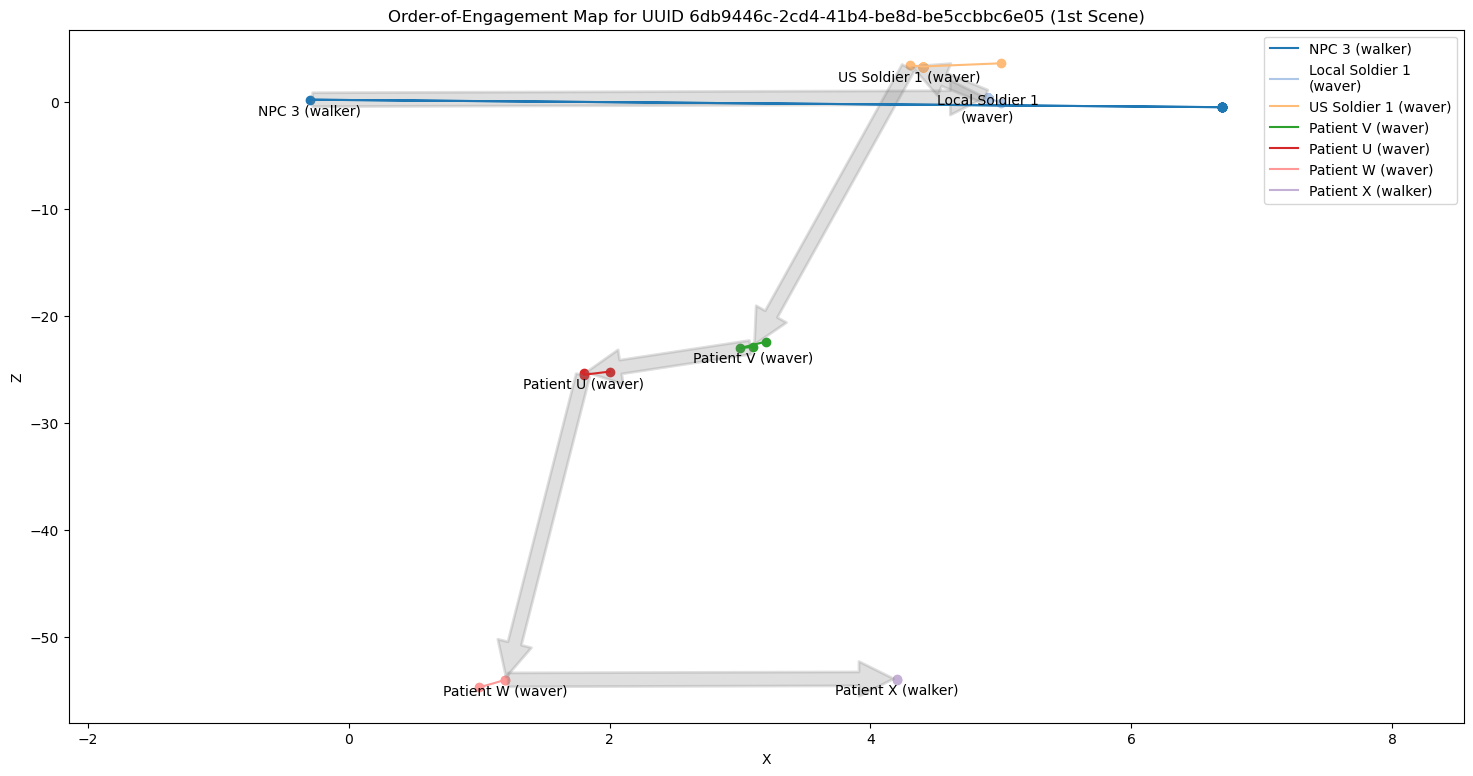

In [251]:

# Plot the time groups sequence with the fewest number of patients
scene_tuple, sequence = sorted([(k, v) for k, v in time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[-6]
mask_series = (participants_df.session_uuid == scene_tuple[0]) & (participants_df.scene_id == scene_tuple[1])
scene_df = participants_df[mask_series]
print(session_uuid, scene_id)
fig, ax = fu.visualize_order_of_engagement(scene_df)

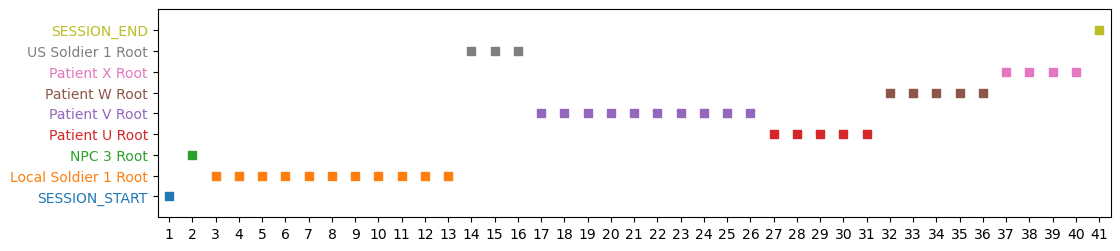

In [253]:

# Plot the time groups sequence with the fewest number of patients
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict.get(patient_df.patient_sort.max(), 'grey')
if(sequence): fig, ax = nu.plot_sequence(sequence, color_dict=None);

In [218]:

[fn for fn in dir() if fn.endswith('_df')]

['dataset_organization_df', 'nuniques_df', 'participant_data_df', 'participant_scenes_df', 'participants_df', 'pivot_df', 'scene_df']

In [211]:

import textwrap

def show_value_counts(nunique_count=2, ax=None):
    """
    Plots the value counts of specified number of unique columns.
    
    Parameters:
        nunique_count: The number of columns with the most unique values to consider.
        ax: An optional matplotlib Axes object to plot on. If not provided, a new figure and axes will be created.
    """
    
    # Get the value counts in their own data frame
    rows_list = []
    for cn in nuniques_dict[nunique_count]:
        for index, value in participant_data_df[cn].value_counts().iteritems():
            rows_list.append({'column_name': cn, 'column_value': index, 'value_count': value})
    nuniques_df = DataFrame(rows_list)
    
    # Pivot the Data Frame to have 'column_value' as columns
    pivot_df = nuniques_df.pivot(index='column_name', columns='column_value', values='value_count').fillna(0)
    
    # Plotting
    if ax is None: fig, ax = plt.subplots(figsize=(10, 8))
    subplot_obj = pivot_df.plot(kind='barh', stacked=True, ax=ax, legend=False)

    # Which barcontainer_obj is associated with which column name?
    for cv, barcontainer_obj in zip(pivot_df.columns, subplot_obj.containers):
        for cn, bar in zip(pivot_df.index, barcontainer_obj.get_children()):
            if bar.get_width() > 0:
                label = get_value_description(cn, cv)
                if not label: label = f'{cv}'#{cn} = 
                # print(f'textwrap.wrap(label, width=bar.get_width()) = textwrap.wrap("{label}", width="{max(5, bar.get_width())}")')
                label = '\n'.join(textwrap.wrap(label, width=max(5, bar.get_width())))
                plt.text(
                    bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                    f'{label}',
                    va='center', ha='center', color='black', fontsize=8
                )
    
    # Set labels and title
    ax.set_xlabel('Participant Count')
    ax.set_ylabel('Column Name')
    ax.set_title('Data Distribution by Participant')
    
    # Print informative message
    print(
        'Among the participants, here are how ' + nu.conjunctify_nouns(
            [f'{k} ({description_dict[k]})' for k in nuniques_dict[nunique_count]]
        ) + ' is proportioned:'
    )

Among the participants, here are how ST_AttribGrp_Sim (High or low on maximization attribute in sim), AD_AttribGrp_Text (High or low on moral deserts attribute in text), AD_AttribGrp_Sim (High or low on moral deserts attribute in sim), MilitaryExp (Identification of military experience), ST_AttribGrp_Text (High or low on maximization attribute in text), ST_Del_Text (Overall rate of delegation on ST scenarios when given delegation choice between 2 DMs, either, or neither; individual scenario DMs), and AD_Del_Omni_Text (Delegation choice between 2 DMs, either, or neither; omnibus DMs) is proportioned:


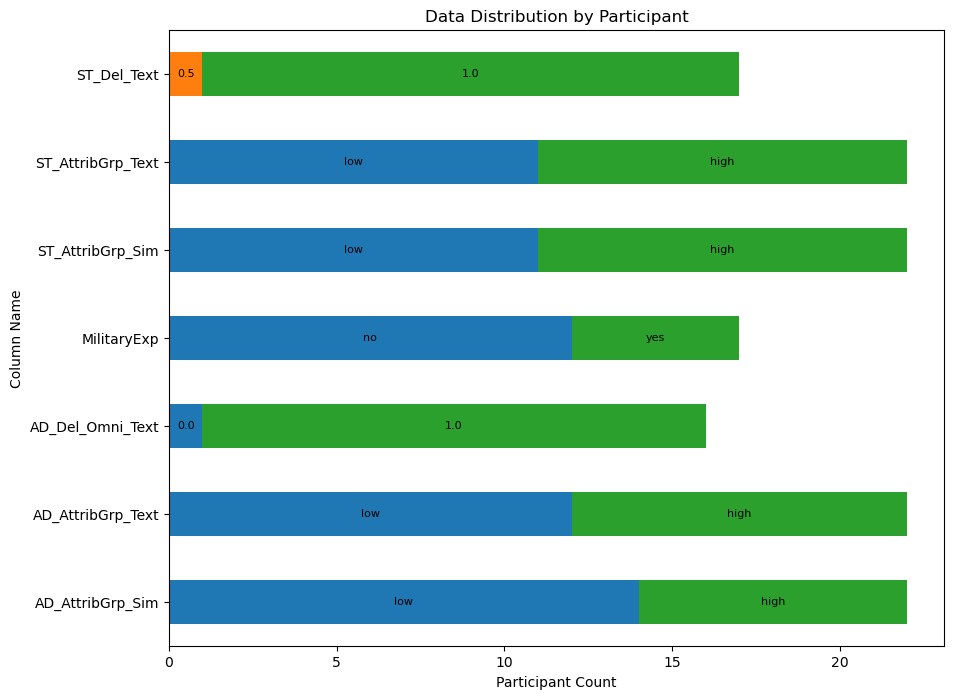

In [212]:

show_value_counts(2)

Among the participants, here are how ST_ConfFC_Omni_Text (Confidence rating in forced choice delegation response; higher numbers is higher confidence; omnibus DMs), Delegation (Overall rate of delegation when given delegation choice between 2 DMs, either, or neither; individual scenario DMs), MedExp (Level of agreement to being a “Seasoned first responder”), YrsMilExp (Years serving in a medical role in the military), AD_Del_Text (Overall rate of delegation on AD scenarios when given delegation choice between 2 DMs, either, or neither; individual scenario DMs), and AD_ConfFC_Omni_Text (Confidence rating in forced choice delegation response; higher numbers is higher confidence; omnibus DMs) is proportioned:


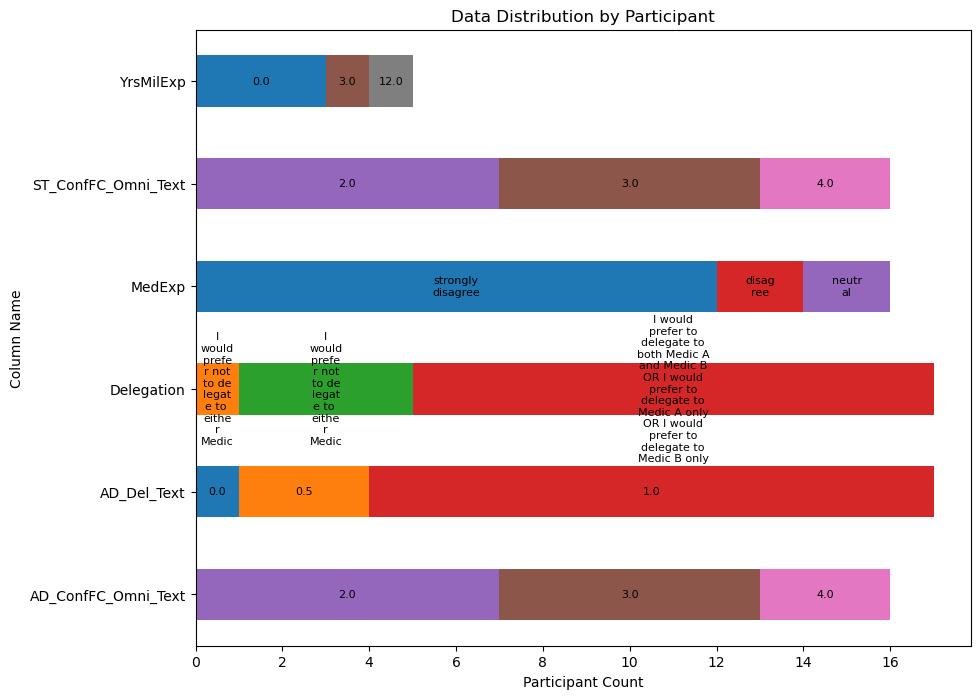

In [213]:

show_value_counts(3)

Among the participants, here are how PropTrust (Average rating on 3-item propensity to trust measure; higher is higher propensity to trust) and MedRole (Categorical variable for role within medical profession) is proportioned:


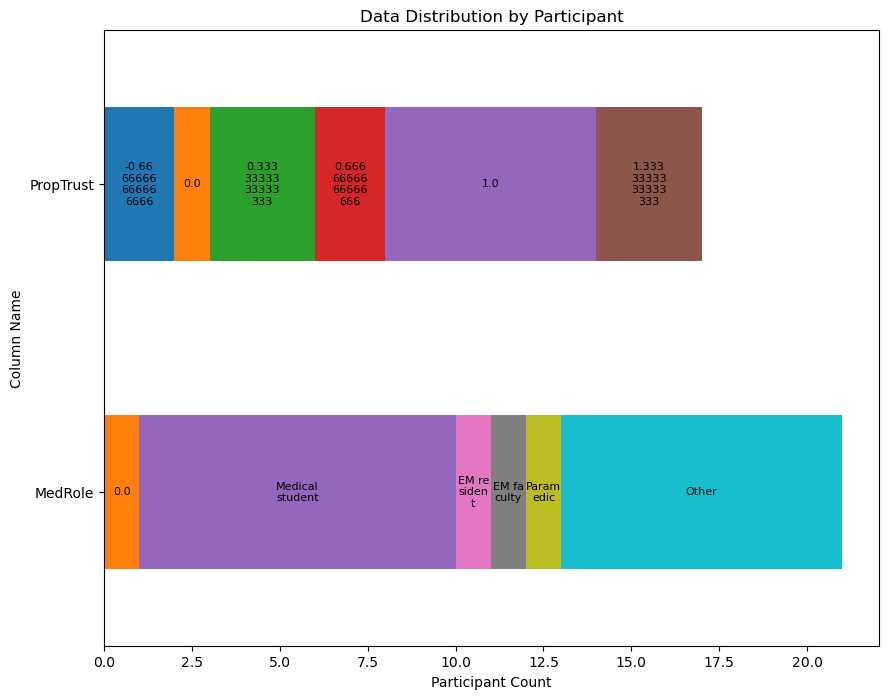

In [214]:

show_value_counts(6)

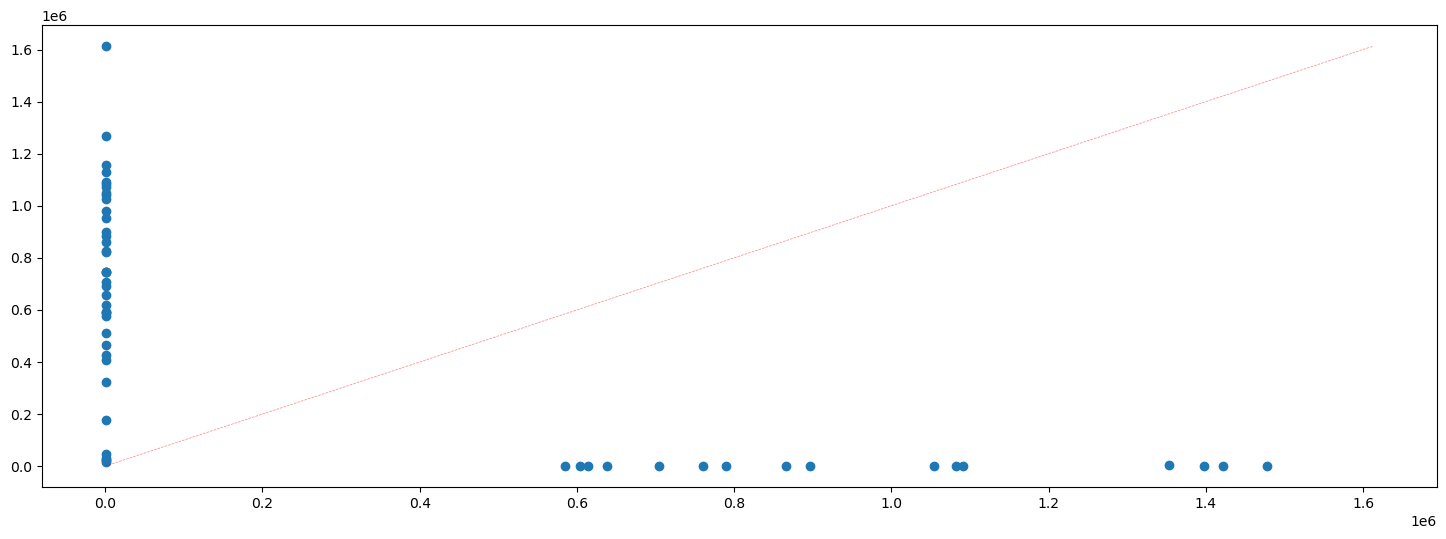

In [27]:

# Plot time to hemorrhage control vs scene start
x_srs = participant_scenes_df.scene_start
y_srs = participant_scenes_df.time_to_hemorrhage_control

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Text', 'ST_KDMA_Sim', 'ST_AttribGrp_Text', 'ST_AttribGrp_Sim', 'ST_Del_Text', 'ST_ConfFC_Text', 'ST_Del_Omni_Text', 'ST_ConfFC_Omni_Text']
['AD_KDMA_Text', 'AD_KDMA_Sim', 'AD_AttribGrp_Text', 'AD_AttribGrp_Sim', 'AD_Del_Text', 'AD_ConfFC_Text', 'AD_Del_Omni_Text', 'AD_ConfFC_Omni_Text']


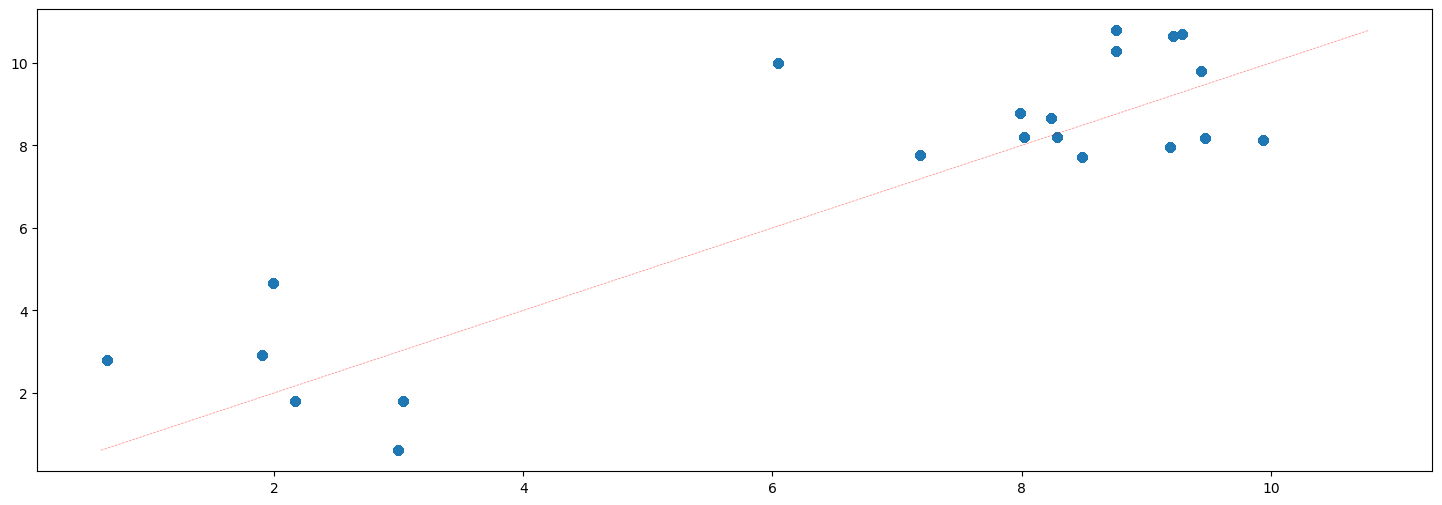

In [21]:

# Performer: Separate visualizations for participants using ADEPT (AD) and SOARTECH (ST) platforms
import matplotlib.pyplot as plt

# print(sum([float(n) for n in '0.434775	0.348326	1.0	0.0	1.0	2.5	1.0	4.0'.split('	')]))
columns_list = [cn for cn in participants_df.columns if cn.startswith('ST_')]
print(columns_list)
y_srs = participants_df[columns_list].T.sum()
# display(y_srs.value_counts())

# print(sum([float(n) for n in '0.416667	0.341667	0.0	0.0	0.5	2.5	1.0	4.0'.split('	')]))
columns_list = [cn for cn in participants_df.columns if cn.startswith('AD_')]
print(columns_list)
x_srs = participants_df[columns_list].T.sum()
# display(x_srs.value_counts())

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Text', 'ST_AttribGrp_Text', 'AD_KDMA_Text', 'AD_AttribGrp_Text', 'ST_Del_Text', 'ST_ConfFC_Text', 'ST_Del_Omni_Text', 'ST_ConfFC_Omni_Text', 'AD_Del_Text', 'AD_ConfFC_Text', 'AD_Del_Omni_Text', 'AD_ConfFC_Omni_Text']
['ST_KDMA_Sim', 'ST_AttribGrp_Sim', 'AD_KDMA_Sim', 'AD_AttribGrp_Sim']


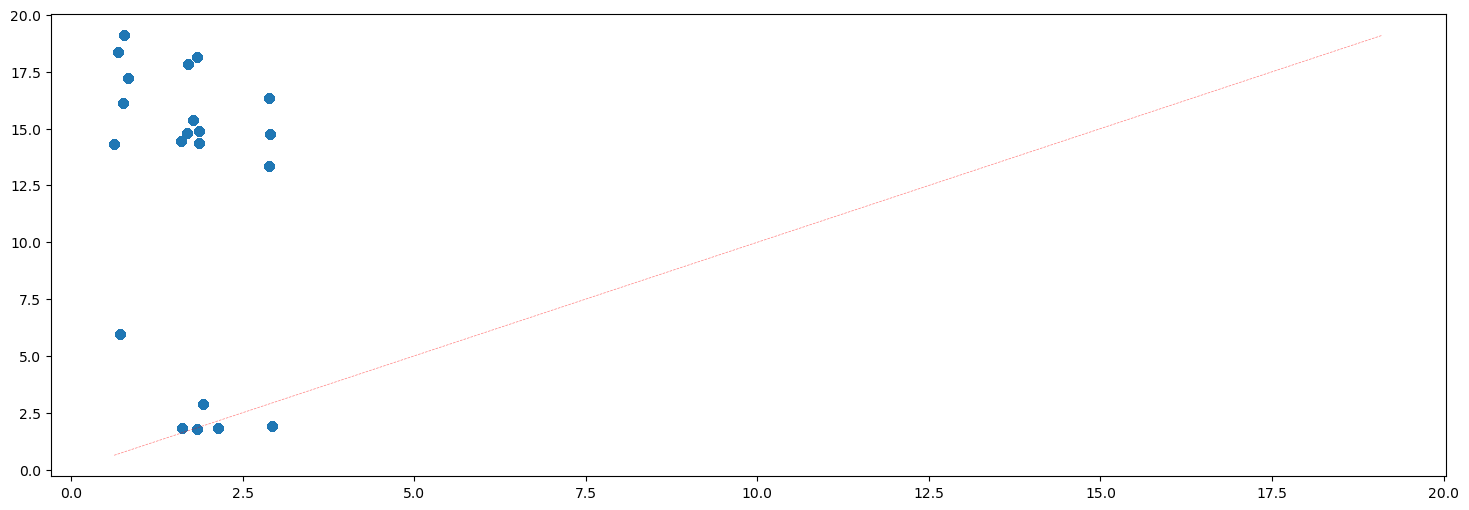

In [20]:

# Fidelity: Separate visualizations for text-based and Virtual Reality (VR) environments
columns_list = [cn for cn in participants_df.columns if cn.endswith('_Text')]
print(columns_list)
y_srs = participants_df[columns_list].T.sum()
columns_list = [cn for cn in participants_df.columns if cn.endswith('_Sim')]
print(columns_list)
x_srs = participants_df[columns_list].T.sum()

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Sim', 'ST_AttribGrp_Sim', 'AD_KDMA_Sim', 'AD_AttribGrp_Sim']
['ST_KDMA_Text', 'ST_AttribGrp_Text', 'AD_KDMA_Text', 'AD_AttribGrp_Text']


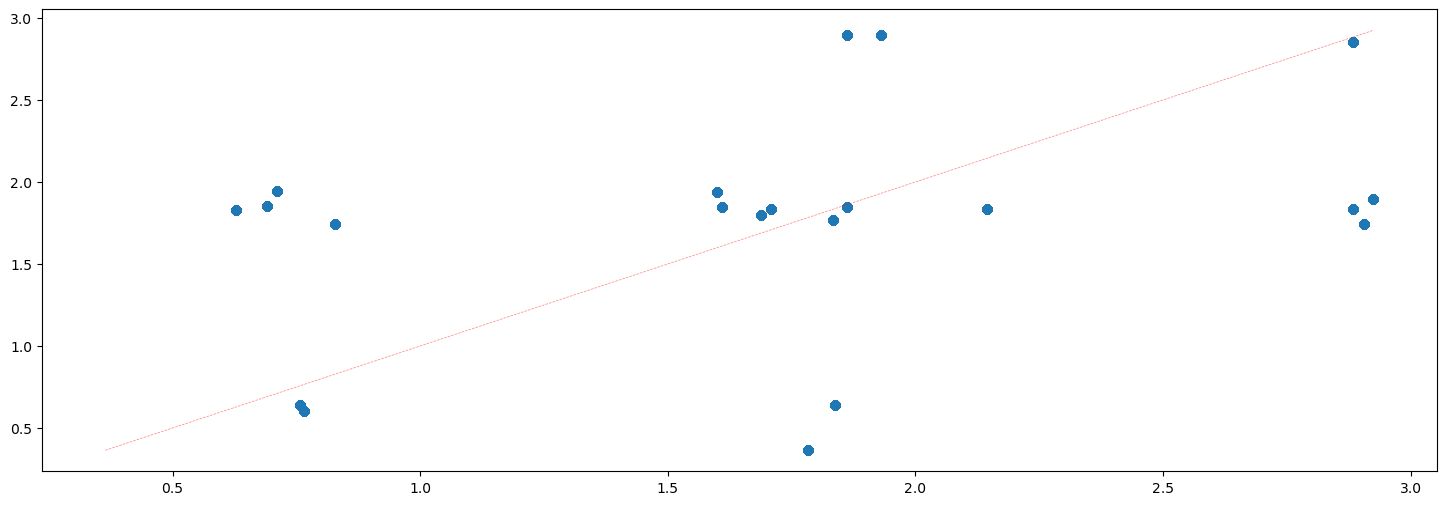

In [19]:

import matplotlib

# Fidelity: Separate visualizations for text-based and Virtual Reality (VR) environments
x_columns_list = [cn for cn in participants_df.columns if cn.endswith('_Sim')]
print(x_columns_list)
x_srs = participants_df[x_columns_list].T.sum()
y_columns_list = [cn.replace('_Sim', '_Text') for cn in x_columns_list]
print(y_columns_list)
y_srs = participants_df[y_columns_list].T.sum()

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

In [ ]:

# Environment: Bar charts or boxplots to compare performance metrics between urban, jungle, desert, and suburban environments
if 'treated_expectant_int' not in participant_scenes_df.columns:
    participant_scenes_df['treated_expectant_int'] = participant_scenes_df.treated_expectant.map(lambda x: int(x))
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)
y_column_names_list = [
    'scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'swaps_to_perfect_order_count',
    'time_to_hemorrhage_control', 'treated_expectant_int'
]
print(y_column_names_list)
for y_column_name in y_column_names_list:
    fu.plot_grouped_box_and_whiskers(
        participant_scenes_df, 'encounter_layout', y_column_name, 'Environment', ' '.join([s.title() for s in y_column_name.split('_')]),
        transformer_name=None, is_y_temporal=False
    )
    # break


## 

In [ ]:

# There are no interesting groupings at the participant level
x_column_names_list = [
    'configData_patientDataList00_raceEthnicity_hairOverride', 'AD_AttribGrp_Text', 'Date', 'AD_KDMA_Text', 'AD_KDMA_Sim'
]#sorted(interesting_columns, key=lambda x: participants_df[x].nunique())[-15:-7]
# for cn in x_column_names_list: print(cn, participants_df[cn].nunique())
y_column_names_list = ['ST_KDMA_Sim', 'ST_KDMA_Text']#sorted(interesting_columns, key=lambda x: participants_df[x].nunique())[-7:]
# for cn in y_column_names_list: print(cn, participants_df[cn].nunique())
# countdown = 5
for x_column_name in x_column_names_list:
    # if countdown < 0: break
    for y_column_name in y_column_names_list:
        # if countdown < 0: break
        x_label = ' '.join([s.title() for s in x_column_name.split('_')])
        y_label = ' '.join([s.title() for s in y_column_name.split('_')])
        if participants_df[x_column_name].dtype == bool:
            participants_df[x_column_name] = participants_df[x_column_name].astype(int)
        try:
            fu.plot_grouped_box_and_whiskers(
                participants_df, x_column_name, y_column_name, x_label,
                y_label, transformer_name=None, is_y_temporal=False
            )
        except Exception as e:
            print(f'{e.__class__} error trying to plot_grouped_box_and_whiskers: {str(e).strip()}')
            print(
                x_column_name, participants_df[x_column_name].unique().tolist(), y_column_name,
                participants_df[y_column_name].unique().tolist()
            )
        # countdown -= 1

In [ ]:

# Create the numeric single value columns
def is_numeric(value):
    try:
        float(value)
        return not isna(value)
    except ValueError: pass
    except TypeError: return False
    try:
        int(value)
        return True
    except ValueError: return False
numeric_single_value_cols_list = []
for cn in single_value_cols_set:
    if participants_df[cn].map(lambda x: is_numeric(x)).all(): numeric_single_value_cols_list.append(cn)

# Add all the numeric single value columns as means
if any(map(lambda cn: f'mean_{cn}' not in participant_scenes_df.columns, numeric_single_value_cols_list)):
    for cn in numeric_single_value_cols_list:
        if f'mean_{cn}' not in participant_scenes_df.columns:
            for (session_uuid, scene_id), scene_df in participant_scenes_df.groupby(fu.scene_groupby_columns):
                mask_series = (participants_df.session_uuid == session_uuid) & (participants_df.scene_id == scene_id)
                mean_numeric_value = participants_df[mask_series][cn].mean()
                mask_series = (participant_scenes_df.session_uuid == session_uuid) & (participant_scenes_df.scene_id == scene_id)
                participant_scenes_df.loc[mask_series, f'mean_{cn}'] = mean_numeric_value
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)

In [ ]:

for x_column_name in x_column_names_list:
    for y_column_name in y_column_names_list:
        if (f'mean_{x_column_name}' in participant_scenes_df.columns) and (f'mean_{y_column_name}' in participant_scenes_df.columns):
            x_label = ' '.join([s.title() for s in f'mean_{x_column_name}'.split('_')])
            y_label = ' '.join([s.title() for s in f'mean_{y_column_name}'.split('_')])
            try:
                fu.plot_grouped_box_and_whiskers(
                    participant_scenes_df, f'mean_{x_column_name}', f'mean_{y_column_name}', x_label,
                    y_label, transformer_name=None, is_y_temporal=False
                )
            except Exception as e:
                print(f'{e.__class__} error trying to plot_grouped_box_and_whiskers: {str(e).strip()}')
                print(
                    f'mean_{x_column_name}', participant_scenes_df[f'mean_{x_column_name}'].unique().tolist(),
                    f'mean_{y_column_name}', participant_scenes_df[f'mean_{y_column_name}'].unique().tolist()
                )

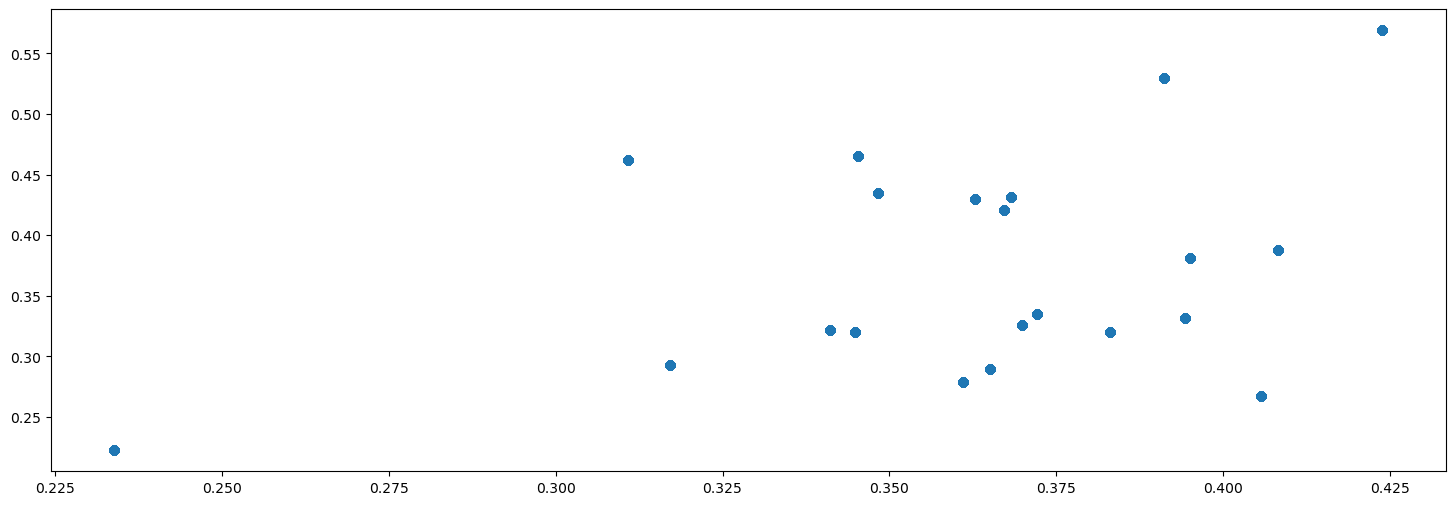

In [72]:

x_srs = participants_df.ST_KDMA_Sim
y_srs = participants_df.ST_KDMA_Text

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)


----

In [4]:

participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp',
    'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]

In [ ]:

anova_df = DataFrame([])
        # Set priority group column
        mask_series = participants_df.patient_id.isin(priority_group_dict.keys())
        if mask_series.any():
            participants_df.loc[mask_series, 'priority_group'] = participants_df.loc[mask_series, 'patient_id'].map(priority_group_dict)
        
        # Get patient sort dictionary
        mask_series = ~participants_df.patient_sort.isnull()
        patient_sort_dict = participants_df[mask_series].set_index('patient_id').patient_sort.to_dict()
        
        # Set patient sort column
        mask_series = participants_df.patient_id.isin(patient_sort_dict.keys())
        if mask_series.any():
            participants_df.loc[mask_series, 'patient_sort'] = participants_df.loc[mask_series, 'patient_id'].map(patient_sort_dict)
        
        # Get the patient stats
        participant_patient_stats_df = fu.get_patient_stats_data_frame(participants_df, verbose=False)
        
        # Create the tag-to-SALT data frame
        tag_to_salt_df = fu.get_is_tag_correct_data_frame(participants_df, groupby_column='encounter_layout')
        
        # Get the percentage tag correct counts for each scene for each group
        correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='encounter_layout')
        
        # Create the ANOVA data frame
        rows_list = []
        for encounter_layout, encounter_layout_df in participant_patient_stats_df.groupby('encounter_layout'):
            patients_list = eval(f'{encounter_layout.lower()}_patients_list')
            encounter_layout_dict = {}
            for cn in encounter_layout_df.columns:
                if 'swap' in cn:
                    print(cn); raise
                    actual_sequence, ideal_sequence, sort_dict = eval(f'fu.get_actual_and_ideal_{cn}_sequences(scene_df)')
                    unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
                    encounter_layout_dict[cn] = nu.count_swaps_to_perfect_order(
                        [unsort_dict[i] for i in ideal_sequence], [unsort_dict[a] for a in actual_sequence]
                    )
            for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
                mask_series = scene_df.patient_id.isin(patients_list)
                if mask_series.any():
                    row_dict = {
                        'participant_id': participant_id, 'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id
                    }
                    for cn in participant_columns: row_dict[cn] = participants_df[cn].mean()
                    for cn in ['priority_group', 'patient_sort']:
                        if cn in encounter_layout_dict: row_dict[f'swaps_to_perfect_{cn}_order_count'] = encounter_layout_dict[cn]
        
                    # Get the start of the whole scene
                    scene_mask_series = True
                    for cn in fu.scene_groupby_columns: scene_mask_series &= (participants_df[cn] == eval(cn))
                    scene_start = fu.get_scene_start(participants_df[scene_mask_series])
                    
                    row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
                    row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
                    row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
                    row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
                    row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max() - scene_start
                    
                    row_dict['is_treating_expectants'] = fu.get_is_treating_expectants(scene_df)
        
                    # Get the whole scene history
                    scene_df = participants_df[scene_mask_series]
                    mask_series = scene_df.patient_id.isin(patients_list)
                    
                    row_dict['triage_time'] = fu.get_triage_time(scene_df[mask_series])
                    row_dict['time_to_last_hemorrhage_controlled'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
                    
                    # Duration of time from when the patient was first approached by the participant until
                    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
                    row_dict['time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
                    
                    mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
                    if mask_series.any():
                        row_dict['mean_percentage_tag_correct'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
                    
                    rows_list.append(row_dict)
        participant_anova_df = DataFrame(rows_list)
        
        # Append the data frame for the current participant to the main data frame
        anova_df = concat([anova_df, participant_anova_df], axis='index')

swaps_to_perfect_patient_sort_order_count


RuntimeError: No active exception to reraise


## Create separate graphs or tables for the following measures (DVs) by environment (urban, jungle, desert, sub) and by fidelity (text, sim) and by performer (ADEPT, SOARTECH)
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [12]:

[cn for cn in scene_df.columns if cn in ['priority_group', 'patient_sort']]

['patient_sort']

In [7]:

print(anova_df.Environment.unique().tolist())
columns_list = ['total_action_count', 'total_assessment_count', 'total_treatment_count', 'total_tag_application_count']
for encounter_layout, encounter_layout_df in anova_df.groupby('Environment'):

['Desert', 'Urban', 'Jungle', 'Submarine']


<ul>
    <li>Explore / create other DVs from the sim that might be indicative of something (movement, what they say, other observables). Can we glean anything else from the logs given what you have explored from the subway dataset?</li>
    <li>Determine which of the above DVs shows a good amount of variability (share the results from above with the group)</li>
    <li>
        Then group or try to predict (through regression or ML or anything else) any of the DVs using the following IVs:
        <ul>
            <li>Participant medical role</li>
            <li>AD alignment score (continuous or group assignment)</li>
            <li>ST alignment score (continuous or group assignment)</li>
            <li>Years of experience</li>
        </ul>
    </li>
</ul>


Conduct some exploratory analysis of the open world segments for the ITM scenarios from the Metrics Evaluation.
For context, results of these analyses is a goal for the 4/30 results meeting (stretch) or the PI meeting (more likely).

<h2>Which factors contribute to the variance in these outcomes?</h2>
Conceptually, I want an exploratory factor analysis using these IVs and DVs. But I suspect we don’t have enough data for that so as close as we can get to that, let’s get creative.
My thought was to keep the environments separate because each participant did 2 of the environments so if we use 1 to explore, we can use the other to confirm. But again, I recognize we do not have power to do these properly.